<a href="https://colab.research.google.com/github/Hamda-Bahri/bfset-experiments/blob/main/notebooks/00_bfset_single_image_annotation_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BFSET – Single Image Annotation Example

This notebook demonstrates how to generate the beard-region bounding box on a **single image**.
It serves as a minimal, reproducible example of the annotation procedure used for BFSET.

Use this notebook to understand the extraction and YOLO-normalized coordinate generation before scaling to the full dataset.

# Florence-2-large sample usage

In [ ]:
!pip install transformers
!pip install einops flash_attn timm

In [ ]:
!pip install --upgrade torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install --upgrade transformers==4.45.2 timm==1.0.9 huggingface-hub==0.25.2 accelerate einops

In [ ]:
from transformers import AutoProcessor, AutoModelForCausalLM
from PIL import Image
import requests
import copy
%matplotlib inline

In [ ]:
model_id = 'microsoft/Florence-2-large'

In [ ]:
model = AutoModelForCausalLM.from_pretrained(model_id, trust_remote_code=True).eval()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_token.py:90: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

configuration_florence2.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-large:
- configuration_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_florence2.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-large:
- modeling_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors:   0%|          | 0.00/1.55G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/51.0 [00:00<?, ?B/s]

In [ ]:
processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)

preprocessor_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

processing_florence2.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-large:
- processing_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


tokenizer_config.json:   0%|          | 0.00/34.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [ ]:
from PIL import Image
import requests

image = Image.open("../assets/image.png").convert("RGB")

prompt = "<CAPTION_TO_PHRASE_GROUNDING> beard"
inputs = processor(text=prompt, images=image, return_tensors="pt").to(model.device)

generated_ids = model.generate(**inputs, max_new_tokens=512)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]

print(generated_text)
# Blurred for copyright protection

</s><s><s><s> beard<loc_328><loc_688><loc_965><loc_999></s>


In [ ]:
def run_example(task_prompt, text_input=None):
    if text_input is None:
        prompt = task_prompt
    else:
        prompt = task_prompt + text_input
    inputs = processor(text=prompt, images=image, return_tensors="pt")
    generated_ids = model.generate(
      input_ids=inputs["input_ids"],
      pixel_values=inputs["pixel_values"],
      max_new_tokens=1024,
      early_stopping=False,
      do_sample=False,
      num_beams=3,
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    parsed_answer = processor.post_process_generation(
        generated_text,
        task=task_prompt,
        image_size=(image.width, image.height)
    )

    return parsed_answer

## define the prediction function

In [ ]:
import os
from PIL import Image

def process_images(directory, extension=".png"):
    files = [f for f in os.listdir(directory) if f.endswith(extension)]

    for filename in files:
        img_path = os.path.join("/content", filename)
        try:
            img = Image.open("../assets/image.png")

            # Exécuter la fonction run_example pour obtenir la description de l'image
            description = run_example('<CAPTION>')

            # Déterminer le chemin du fichier texte pour la description
            txt_filename = os.path.splitext(filename)[0] + ".txt"
            txt_path = os.path.join(directory, txt_filename)

            # Écrire la description dans le fichier texte
            with open(txt_path, "w") as txt_file:
                txt_file.write(description)

            print(f"Processed {img_path} and saved description to {txt_path}")

        except Exception as e:
            print(f"Error processing {img_path}: {e}")
# Blurred for copyright protection

In [ ]:
def plot_bbox(image, data):
   # Create a figure and axes
    fig, ax = plt.subplots()

    # Display the image
    ax.imshow(image)

    # Plot each bounding box
    for bbox, label in zip(data['bboxes'], data['labels']):
        # Unpack the bounding box coordinates
        x1, y1, x2, y2 = bbox
        # Create a Rectangle patch
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')
        # Add the rectangle to the Axes
        ax.add_patch(rect)
        # Annotate the label
        plt.text(x1, y1, label, color='white', fontsize=8, bbox=dict(facecolor='red', alpha=0.5))

    # Remove the axis ticks and labels
    ax.axis('off')

    # Show the plot
    plt.show()

In [ ]:
task_prompt = '<CAPTION_TO_PHRASE_GROUNDING>'
results = run_example(task_prompt, text_input="beard")
print(results)

{'<CAPTION_TO_PHRASE_GROUNDING>': {'bboxes': [[73.58399963378906, 154.447998046875, 216.04800415039062, 223.88800048828125]], 'labels': ['beard']}}


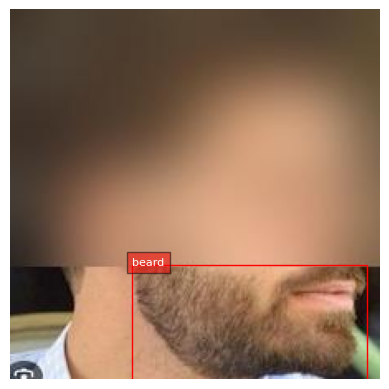

In [ ]:
plot_bbox(image, results['<CAPTION_TO_PHRASE_GROUNDING>'])